# Hồi quy Logistic sử dụng mạng Neuron Nhân tạo

Chúng ta sẽ xây dựng một máy học nhận diện mèo.

**Hướng dẫn:**
- Không sử dụng vòng lặp trong code, trừ khi có hướng dẫn cụ thể yêu cầu bạn sử dụng.

**Nội dung:**
- Xây dựng kiến trúc chung cho một thuật toán máy học, bao gồm:
    - Khởi tạo các tham số
    - Tính toán hàm chi phí (cost function) và gradient
    - Sử dụng một thuật toán tối ưu (hướng giảm gradient)
- Kết hợp 3 hàm trên vào hàm main, theo đúng thứ tự.

## 1 - Các thư viện ##

Đầu tiên, chúng ta chạy cell phía dưới để import tất cả các thư viện cần thiết.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

# sets the backend of matplotlib to the 'inline' backend
%matplotlib inline

## 2 - Tổng quan về bài toán ##

**Phát biểu bài toán**: Bạn có một dataset ("data.h5") chứa:
    - một tập những ảnh với nhãn là cat (y=1) và non-cat (y=0) dùng để luyện máy học
    - một tập những ảnh với nhãn cat và non-cat dùng để kiếm tra.
    - mỗi ảnh có kích thước (num_px, num_px, 3) với 3 là số kênh của ảnh (ứng với Red-Green-Blue hay RGB). Mỗi ảnh đều có chiều cao và chiều rộng bằng nhau.

Bạn sẽ xây dựng một thuật toán nhận diện mèo trong ảnh có khả năng phân biệt giữa ảnh có và không có mèo.

Hãy bắt đầu bằng việc làm quen với dataset. Nhập dữ liệu từ file vào notebook bằng đoạn code sau.

In [2]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Chú ta thêm từ "orig" vào cuối tên của dataset (dữ liệu train và test) vì ta sẽ tiền xử lý dữ liệu. Sau khi tiền xử lý, ta được hai bộ dữ liệu `trainset_x` và `test_set_x`.

Mỗi hàng ở trong `train_set_x_orig` và `test_set_x_orig` là một mảng đại diện cho một ảnh. Bạn có thể hiển thị một ảnh ví dụ bằng cách chạy cell sau. Thay đổi giá trị biến index và chạy lại để cập nhật ảnh.

y = [1], it's a 'cat' picture.


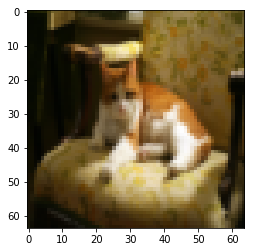

In [3]:
# Example of a picture
index = 7
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + 
       ", it's a '" + 
       classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture.")

Nhiều lỗi trong lập trình deep learning đến từ việc các chiều của các ma trận hay vector không khớp nhau.

**Bài tập:** Tìm giá trị cho:
    - m_train (số mẫu trong tập train)
    - m_test (số mẫu trong tập test)
    - num_px (= chiều cao = chiều rộng của ảnh)

Biết rằng `train_set_x_orig` là một mảng numpy với kích thước (m_train, num_px, num_px, 3).

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Đầu ra mong đợi cho m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>m_train</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
  
</table>


Để tiện xử lý, ta sẽ biến dạng ảnh từ kích thước (num_px, num_px, 3) về kích thước (num_px  $∗$  num_px  $∗$  3, 1).
Sau đó, dữ liệu luyện sẽ là một mảng mà mỗi **cột** là một bức ảnh được trải phằng về 1 chiều).

**Bài tập:** Biến dạng dữ liệu train và test sao cho mỗi ảnh có kích thước (num_px, num_px, 3) được trải phằng về một vector có kích thước (num\_px $\times$ num\_px $\times$ 3, 1).

Một mẹo khi trải phẳng ma trận X có kích thước (a,b,c,d) về ma trận X_flatten có kích thước (b$*$c$*$d, a) is là sử dụng: 
```python
X_flatten = X.reshape(X.shape[0], -1).T
```
X.T là chuyển vị của X

In [7]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape((train_set_x_orig.shape[0], -1)).T
test_set_x_flatten = test_set_x_orig.reshape((test_set_x_orig.shape[0], -1)).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Đầu ra mong đợi**: 

<table style="width:45%">
  <tr>
    <td>train_set_x_flatten.shape</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>train_set_y.shape</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>test_set_x_flatten.shape</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>test_set_y.shape</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>sanity check after reshaping</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

Để biểu diễn ảnh màu trong máy tính, 3 kênh màu đỏ, xanh lục và xanh lá cây (RGB) được sử đụng cho mỗi pixel, và mỗi pixel có giá trị là một vector gồm có 3 phần tử tương ứng, mỗi phần tử có giá trị trong khoảng từ 0 đến 255.

Một ví dụ thông thường trong máy học là chuẩn hóa dữ liệu, ví dụ như lấy giá trị dữ liệu trừ đi kì vọng của dataset, sau đó chia kết quả cho độ lệch chuẩn của dataset, còn gọi là **Z-score**. 

Nhưng với dữ liệu ảnh này, một cách đơn giản và tiện hơn nhưng cũng khá hiệu quả là chia giá trị mỗi pixel cho 255 (giá trị cực đại của mỗi kênh của một pixel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Sau đây là bước chuẩn hóa dữ liệu.

In [8]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
**Ghi nhớ:**

Những bước trong tiền xử lý dữ liệu cho dataset mới:
- Tìm ra số chiều và kích thước các chiều của bài toán.
- Biến đổi dataset sao cho mỗi mẫu trong dataset là một vector có cùng kích thước.
- Chuẩn hóa dữ liệu

## 3 - Kiến trúc chung của một thuật toán học ##


Bạn sẽ xây dựng một thuật toán hồi quy Logistic sử dụng mạng neuron. **Hồi quy Logistic thực ra là một mạng neuron đơn giản!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Biểu thức toán học của thuật toán**:

Với mỗi mẫu $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Hàm chi phí được tính bằng trung bình chi phí của tất cả các mẫu:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Các bước quan trọng**: 
    - Khởi tạo những tham số cho mô hình
    - Học (cập nhật) các tham số điểu cực tiểu hóa phi phí
    - Sử dụng các tham số học được để đưa ra dự đoán (trên bộ dữ liệu test)
    - Phân tích kết quả dự đoán và kết luận về mô hình máy học đã luyện được.

## 4 - Xây dựng các phần của thuật toán ## 

Các bước chính để xây dựng một mạng Neuron:
1. Xác định kiến trúc của mô hình (số đặc trưng đầu vào, số kết quả đầu ra, số lớp trong mạng, cấu trúc của mỗi lớp, số lượng tham số, etc) 
2. Khởi tạo giá trị ban đầu cho các tham số cho mô hình
3. Vòng lặp:
    - Tính hàm loss (hay cost) (lan truyền thẳng)
    - Tính gradient dựa trên giá trị hàm loss (lan truyền ngược)
    - Cập nhật giá trị cho các tham số dựa trên gradient tính được (phương pháp hướng giảm gradient)

Bạn thường sẽ xây dựng các bước độc lập sau đó tích hợp vào chung một hàm gọi là `model()`.

### 4.1 - Helper functions

**Bài tập**: Triển khai hàm `sigmoid()`. Hàm sigmoid được sử dụng trong công thức của hồi quy tuyến tính: $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ để đưa ra dự đoán. Lưu ý sử dụng `np.exp()` trong triển khai.

In [13]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1. / (1 + np.exp(-1. * z) + np.finfo(np.float64).eps)
    ### END CODE HERE ###
    
    return s

In [14]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Đầu ra mong đợi**:

<table>
  <tr>
    <td>sigmoid([0, 2])</td>
    <td> [ 0.5,         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Khởi tạo các tham số

**Bài tập:** Triển khai cell phía dưới để khởi tạo các tham số . Hãy khởi tạo bộ tham số `w` là vector với toàn giá trị 0. Nên sử dụng hàm `numpy.zeros()`.

In [15]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim, 1))
    b = 0.
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [16]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


**Đầu ra mong đợi**: 


<table style="width:35%">
    <tr>
        <td>   w   </td>
        <td> [[ 0.][ 0.]] </td>
    </tr>
    <tr>
        <td>   b   </td>
        <td> 0 </td>
    </tr>
</table>

Với kích thước ảnh đầu vào, `w` sẽ có kích thước (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Lan truyền thẳng và lan truyền ngược

Bây giờ các tham số đã được khởi tạo, bạn có thể lan thuyền thẳng và ngược để cập nhật các tham số.

**Bài tập:** triển khai hàm `propagate()` tính hàm chi phí và gradient của nó.

**Gợi ý**:

Forward Propagation:
- có X
- Tính $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Tính hàm chi phí: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Đây là 2 công thức bạn sẽ sử dụng: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [21]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.matmul(w.T, X) + b)                                    # compute activation
    cost = -1./m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))        # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1./m * np.matmul(X, (A - Y).T)
    db = 1./m * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [22]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.00145557813678406
cost = 5.801545319382507


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>   dw   </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>   db   </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>   cost   </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Tối ưu
- Bạn đã khởi tạo tham số.
- Bạn cũng đã tính hàm chi phí và gradient của nó.
- Bây giờ bạn cần cập nhật trọng số sử dụng phương pháp hướng giảm gradient.

**Bài tập**: Thực thi hàm tối ưu. Mục tiêu là học $w$ và $b$ bằng cách cực tiểu hóa hàm $J$. Với mỗi tham số $\theta$, công thức cập nhật là $ \theta = \theta - \alpha \text{ } d\theta$, với $\alpha$ là "tốc độ học" (learning rate).

In [25]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [26]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067638


**Expected Output**: 

<table style="width:40%">
    <tr>
        <td> w </td>
        <td>[[ 0.19033591] [ 0.12259159]] </td>
    </tr>
    <tr>
        <td> b </td>
        <td> 1.92535983008 </td>
    </tr>
    <tr>
        <td> dw </td>
        <td> [[ 0.67752042] [ 1.41625495]] </td>
    </tr>
    <tr>
        <td> db </td>
        <td> 0.219194504541 </td>
    </tr>

</table>

**Bài tập**: Hàm ở trên sẽ trả về tham số đã học được $w$ và $b$. Ta có thể sử dụng $w$ và $b$ để dự đoán nhãn cho dataset $X$. Hãy thực thi hàm `predict()`. Có hai bước:

1. Tính $\hat{Y} = A = \sigma(w^T X + b)$

2. Chuyển đầu ra thành 0 (nếu activation <= 0.5) hoặc 1 (nếu activation > 0.5), lưu kết quả dự đoán vào vector `Y_prediction`. Nếu muốn, bạn có thể sử dụng `if`/`else` trong vòng lặp `for` (mặc dù có các để vector hóa nó). 

In [27]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.matmul(w.T, X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[A <= 0.5] = 0
        Y_prediction[A > 0.5] = 1 
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [28]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             predictions
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**Ghi nhớ:**
Bạn vừa thực thi những hàm sau:

- khởi tạo (w,b)
- Cực tiểu hóa hàm chi phí liên tục để cập nhật tham số (w,b):
    - tính hàm chi phí và gradient của nó
    - cập nhật các tham số sử dụng hướng giảm gradient
- Sử dụng tham số học được (w,b) để dự đoán nhãn cho tập những mẫu.

## 5 - Ghép các hàm lại thành một mô hình ##

Bây giờ bạn sẽ hiểu cách một mô hình deep learning được xây dựng dựa trên việc ghép các thành phần (những hàm đã được thực thi ở các phần trước) theo đúng thứ tự:

**Bài tập**: Thực thi hàm `model`. Sử dụng các định danh sau:
    - `Y_prediction_test` dành cho dự đoán trên tập dữ liệu test.
    - `Y_prediction_train` dành cho dự đoán trên tập dữ liệu train.
    - w, costs, grads là các đầu ra của hàm optimize()

In [29]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Chạy cell sau để luyện mô hình.

In [30]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:45%"> 
    <tr>
        <td> Cost after iteration 0</td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> Train Accuracy  </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>Test Accuracy </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Bình luận**: Độ chính xác của tập luyện đã gần 100%. Đây là một cách kiểm tra tốt: Mô hình của bạn hoạt động và có khả năng khớp với dữ liệu luyện. độ chính xác trên tập test là 68%. Đây không phải là kết quả tệ cho một mô hình đơn giản, với số lượng mẫu mà chúng ta sử dụng cũng như mô hình hồi quy logistic là một phân lớp tuyến tính. Đừng lo lắng, bạn sẽ xây dựng được những phân lớp tốt hơn trong những tuần tiếp theo!

Bạn cũng có thể thấy mô hình này đã **overfit** trên dữ liệu luyện. Sử dụng code phía dưới (và thay đổi giá trị biến `index`) bạn có thể thấy dự đoán của những bức ảnh trong tập test.

y = 1, you predicted that it is a "cat" picture.


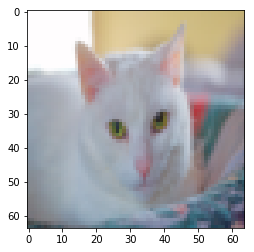

In [44]:
# Example of a picture that was wrongly classified.
index = 2
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
# print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")
print("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") + "\" picture.")

Biểu diễn hàm chi phí và gradients.

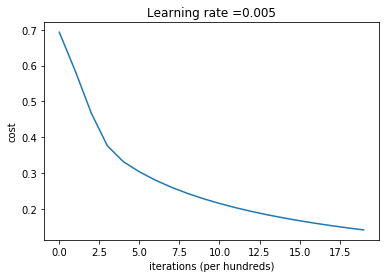

In [45]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Nhận xét**:
Bạn có thể thấy hàm chi phí giảm. Điều này chỉ ra rằng các tham số đã được học. Tuy nhiên bạn càng tăng số vòng lặp lên, độ chính xác trên dữ liệu luyện càng tăng nhưng độ chính xác trên dữ liệu test giảm xuống. Đây được gọi là overfitting. 

## 6 - Further analysis (optional/ungraded exercise) ##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



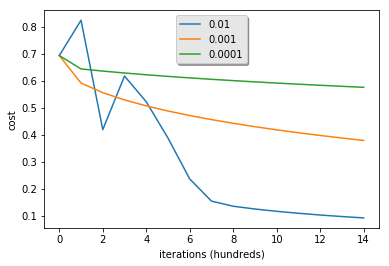

In [46]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 


## 7 - Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [ ]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "my_image.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<font color='blue'>
**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model().
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
    - Play with the learning rate and the number of iterations
    - Try different initialization methods and compare the results
    - Test other preprocessings (center the data, or divide each row by its standard deviation)

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c